# We import the libraries

In [15]:
import numpy as np
import json as json

from tsp_genetic import TSP_Genetic
from parent_selection import parent_selection
from mutation import mutation
from crossover import crossover
from datetime import datetime

# Functions

In [2]:
def read_data(filepath):
    """ Read the data from the file and return the distance matrix and the list of cities positions """

    with open(filepath, 'r') as file:
        distance_matrix = False
        city_list = False
        for line in file:
            line = line.strip()
            # Create the distance matrix and the list of cities
            if line.startswith('DIMENSION'):
                dimension = int(line.split()[-1])
                cities = np.zeros((dimension, 2))
                distances = np.zeros((dimension, dimension))
                i=0
                j=0
            
            # What do we do with the line
            if line.startswith('EDGE_WEIGHT_SECTION'):
                distance_matrix = True
                continue
            elif line.startswith('DISPLAY_DATA_SECTION'):
                distance_matrix = False
                city_list = True
                continue
            elif line.startswith('EOF'):
                break
            
            # Save data
            if distance_matrix:
                distances[i,] = [int(x) for x in line.split()]
                i += 1
            if city_list:
                cities[j,] = line.split()[-2:]
                j += 1
        
        return distances, cities

In [3]:
def create_population(size : int, cities : np.ndarray):
    """ Create the initial population """

    population = []
    for i in range(size):
        population.append(np.random.permutation(cities.shape[0]))
    
    return population

# Usage example

In [4]:
# We read the data:
distances,cities= read_data('bays29.tsp')

In [8]:
# Instantiate the genetic algorithm
genetic= TSP_Genetic(generations=100,
                    print_results=True,
                    print_rate=10,
                    m_rate=0.05,
                    c_rate=0.8,
                    select_parents="tournament_selection",
                    tournament_size=5,
                    crossover="OX1",
                    crossover_call="()", 
                    mutation="insertion",
                    elitism=3,
                    results_path= "fitness_statistics.json",
                    save_results=True)

In [6]:
# Create the population:
population = create_population(200, cities)

INFO:root:Generation 0 - Best cromosome: [20  3 18  6 23 25 12  7  8 10 11  0 27  2 16 13 22 17 24 28  1  5 26  9
 14 19  4 21 15], Best fitness: 4688.0


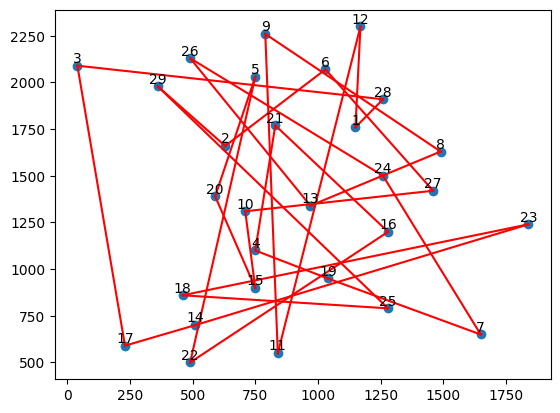

INFO:root:Generation 10 - Best cromosome: [ 3 23 26  4 27 20  1  0 22 15 12  9 14 18 17  6 24 13 16 10 21 19  5 11
 25  8  2 28  7], Best fitness: 3639.0


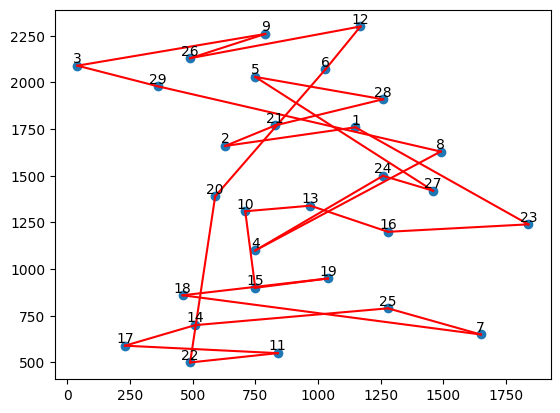

INFO:root:Generation 20 - Best cromosome: [23 26  4 27 20  1  0 22 15  3 12  9 14 18 17  6 24 13 16 21 10 19  5 11
 25  2 28  8  7], Best fitness: 3311.0


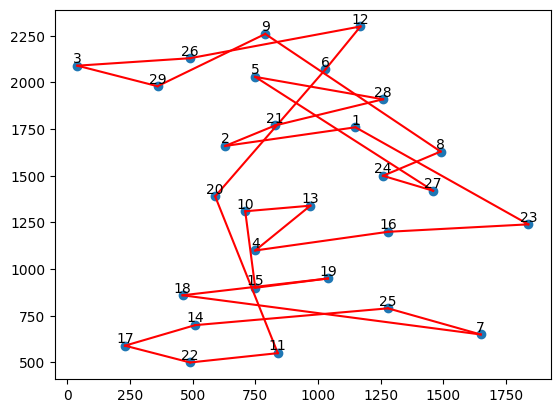

INFO:root:Generation 30 - Best cromosome: [23 26 27 20  1  0 22 15 18 12  9 14  3 17  6 24 13 16 21 10 19  5  4 25
  2 28  8 11  7], Best fitness: 3002.0


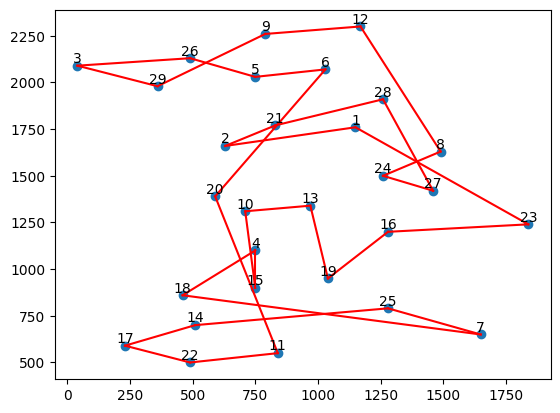

INFO:root:Generation 40 - Best cromosome: [23 22 26 27 20  1  0 15 12  9 14 17 18  6 24 13 16 21 10  3 19  5  4 25
  2 28  8 11  7], Best fitness: 2849.0


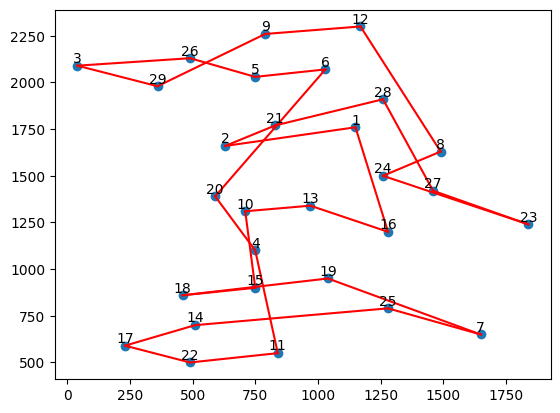

INFO:root:Generation 50 - Best cromosome: [22 26 23 27  0 20  1 15 12 17 14 18  6 24 13 16 21 10  3  9 19  5  4 25
  2 28  8 11  7], Best fitness: 2714.0


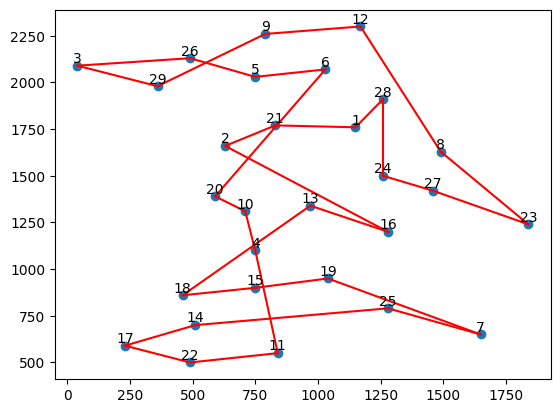

INFO:root:Generation 60 - Best cromosome: [22 26 23 27  0 20  1 12 15 17 14 18  6 24 13 16 21 10  3  9 19  5  4 25
  2 28  8 11  7], Best fitness: 2652.0


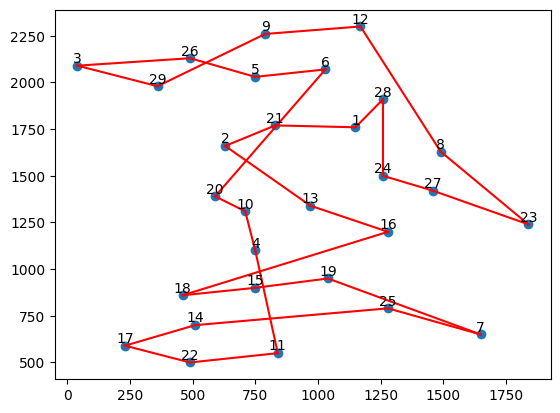

INFO:root:Generation 70 - Best cromosome: [22 26 23 27  0 20 12 15 17 14 18  6 24 13 16 21 10  3  9 19  1  5  4 25
  2 28  8 11  7], Best fitness: 2631.0


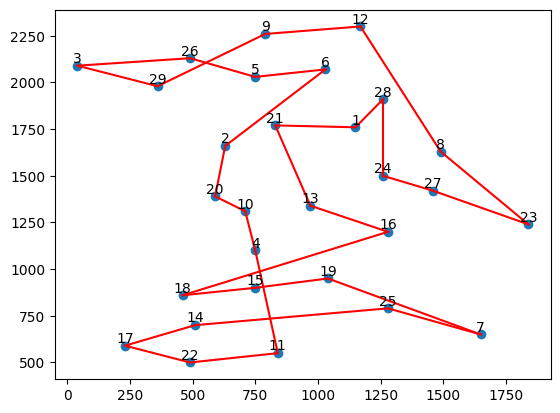

INFO:root:Generation 80 - Best cromosome: [22 26 15 23 27  0 20 12 17 14 18  6 24 13 16 21 10  3  9 19  1  5  4 25
  2 28  8 11  7], Best fitness: 2619.0


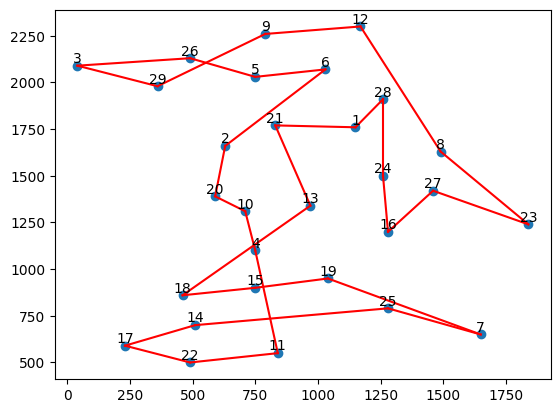

INFO:root:Generation 90 - Best cromosome: [22 26 15 23 27  0 20 12 17 14 18  6 24 13 16 21 10  3  9 19  1  4 25  2
 28  8 11  5  7], Best fitness: 2522.0


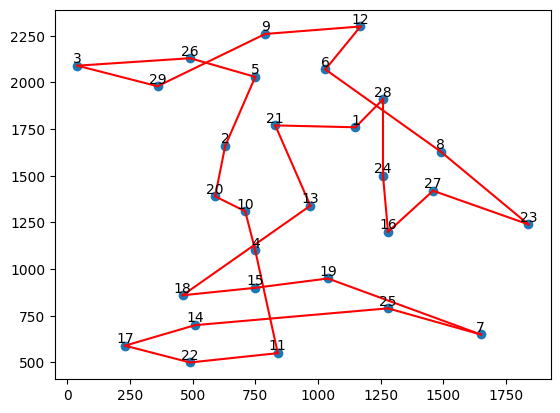

INFO:root:Generation 99 - Best cromosome: [22 26 15 23 27  0 20 12 17 14 18  6 24 13 16 21 10  3  9 19  1  4 25  2
 28  8 11  5  7], Best fitness: 2522.0


In [9]:
# Run the genetic algorithm
final_population = genetic.run(population,cities,distances)

In [8]:
# Access the results for every generation metrics
import json

with open('fitness_statistics.json', 'r') as file:
    data = json.load(file)

print(data[0])

{'0': {'mean_fitness': 6025.14, 'median_fitness': 6065.5, 'min_fitness': 5189.0, 'max_fitness': 6868.0}}


# Grid Seach

In [10]:
# Define the parameter grid
param_grid = {
    "population_size" : [50, 200],
    "elitism" : [0, 1, 3],
    "generations" : [100, 200],
    "m_rate" : [0.01, 0.05, 0.1],
    "c_rate" : [0.6, 0.8, 1],
    "select_parents" : ["tournament_selection", "roulette_selection","rank_roulette_selection","random_selection"],
    "crossover" : ["POS", "OX1"],
    "mutation" : ["exchange", "insertion", "IVM"],
    "tournament_size" : [3, 5] # Only for tournament selection
}

In [13]:
# Dictionary to store the results
results = []
best_distance = np.inf
i=0

#Grid Search
for population_size in param_grid["population_size"]:
    # Generate the population
    population = create_population(population_size, cities)
    #Iterate over the parameters
    for generations in param_grid["generations"]:
        for m_rate in param_grid["m_rate"]:
            for c_rate in param_grid["c_rate"]:
                for crossover in param_grid["crossover"]:
                    for mutation in param_grid["mutation"]:
                        for elitism in param_grid["elitism"]:
                            for select_parents in param_grid["select_parents"]:
                                # Select the tournament size for tournament selection:
                                if select_parents == "tournament_selection":
                                    for t_size in param_grid["tournament_size"]:
                                        genetic= TSP_Genetic(generations=generations,
                                                    print_results=False,
                                                    print_rate=10,
                                                    m_rate=m_rate,
                                                    c_rate=c_rate,
                                                    select_parents=select_parents,
                                                    tournament_size=t_size,
                                                    crossover=crossover,
                                                    crossover_call="()", # We dicided to use the default parameters for the crossover
                                                    mutation=mutation,
                                                    elitism=elitism,
                                                    results_path= "",
                                                    save_results=False)
                                        final_population, fitness = genetic.run(population,cities,distances)
                                # For the other selection methods
                                else:
                                    t_size = None
                                    genetic= TSP_Genetic(generations=generations,
                                                        print_results=False,
                                                        print_rate=10,
                                                        m_rate=m_rate,
                                                        c_rate=c_rate,
                                                        select_parents=select_parents,
                                                        tournament_size=t_size,
                                                        crossover=crossover,
                                                        crossover_call="()", 
                                                        mutation=mutation,
                                                        elitism=elitism,
                                                        results_path= "",
                                                        save_results=False)
                                    final_population, fitness = genetic.run(population,cities,distances)
                                
                                # Update the best parameters
                                if fitness < best_distance:
                                    best_distance = fitness
                                    best_params = {
                                        "population_size" : population_size,
                                        "elitism" : elitism,
                                        "generations" : generations,
                                        "m_rate" : m_rate,
                                        "c_rate" : c_rate,
                                        "select_parents" : select_parents,
                                        "crossover" : crossover,
                                        "mutation" : mutation,
                                        "tournament_size" : t_size
                                    }

                                # Save the results
                                i+=1
                                parameters = {
                                    "population_size" : population_size,
                                    "elitism" : elitism,
                                    "generations" : generations,
                                    "m_rate" : m_rate,
                                    "c_rate" : c_rate,
                                    "select_parents" : select_parents,
                                    "crossover" : crossover,
                                    "mutation" : mutation,
                                    "tournament_size" : t_size
                                }
                                results.append({
                                    "parameters" : parameters,
                                    "fitness" : fitness
                                })

                                

In [18]:
# Json file with the results
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
results_file=f'grid_search_results_{timestamp}.json'

# Save the results
with open(results_file, "w") as f:
    json.dump({index: result for index, result in enumerate(results)}, f)

In [19]:
best_distance, best_params

(np.float64(2096.0),
 {'population_size': 200,
  'elitism': 1,
  'generations': 200,
  'm_rate': 0.1,
  'c_rate': 0.6,
  'select_parents': 'tournament_selection',
  'crossover': 'POS',
  'mutation': 'insertion',
  'tournament_size': 5})